# ScientISST MOVE: Getting Started in EDF format
Please cite:
_Saraiva et al., ScientISST MOVE: Annotated Multimodal Naturalistic Dataset Recorded During Everyday Life Activities Using Wearable Devices, Scientific Data (2023)_

## A. Download Dataset

In [ ]:
import mne as mne
import pyedflib as pyedflib
import wget, zipfile, os
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

# Download dataset in EDF+ format
url = 'https://zenodo.org/record/8300972/files/edf.zip?download=1'
filename = wget.download(url)  # into to the current directory

# Decompress zip file
with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall('edf.zip')

# Delete zip file
os.remove(filename)

## B. Install MNE

In [ ]:
# Create a virtual environment
!python3 -m venv venv  # comment this if already created, or change python version

# Install MNE or PyEDFlib
!pip3 install mne  # comment this if already installed
!pip3 install pyedflib  # comment this if already installed

# Activate virtual environment
!source venv/bin/activate  # comment this if already activated

## 1. Load and explore
Let's use subject F408 as an example. Consider we will need only the ECGs for this project.

In [14]:
import mne, pyedflib

code = 'F408'
path = f'edf/{code}/scientisst_chest.edf'

# open with mne
raw = mne.io.read_raw_edf(path, preload=False)

# open with pyedflib
f = pyedflib.EdfReader(path)

raw

Extracting EDF parameters from /Users/saraiva/PycharmProjects/ScientISST-MOVE/usage/edf/F408/scientisst_chest.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/var/folders/1g/sc9mrb8x18s7r9d97p9glqch0000gp/T/ipykernel_25148/1290326672.py:7: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(path, preload=False)


<RawEDF | scientisst_chest.edf, 5 x 1177500 (2355.0 s), ~9 kB, data not loaded>

Above we can see a tabular description of the EDF+ file. From this we can gather that it has 5 channels, with 39 minutes recording (not necessarily useful), and the sampling frequency is 500 Hz.

We can also get information about the annotations:

In [16]:
for a in raw.annotations:
    print(a)

OrderedDict([('onset', 0.0), ('duration', 37.8), ('description', 'baseline'), ('orig_time', datetime.datetime(2000, 1, 1, 0, 0, 1, tzinfo=datetime.timezone.utc))])
OrderedDict([('onset', 188.412), ('duration', 65.295), ('description', 'lift'), ('orig_time', datetime.datetime(2000, 1, 1, 0, 0, 1, tzinfo=datetime.timezone.utc))])
OrderedDict([('onset', 287.772), ('duration', 40.053), ('description', 'greetings'), ('orig_time', datetime.datetime(2000, 1, 1, 0, 0, 1, tzinfo=datetime.timezone.utc))])
OrderedDict([('onset', 357.912), ('duration', 100.68), ('description', 'gesticulate'), ('orig_time', datetime.datetime(2000, 1, 1, 0, 0, 1, tzinfo=datetime.timezone.utc))])
OrderedDict([('onset', 498.632), ('duration', 131.282), ('description', 'walk_before'), ('orig_time', datetime.datetime(2000, 1, 1, 0, 0, 1, tzinfo=datetime.timezone.utc))])
OrderedDict([('onset', 815.942), ('duration', 1530.86), ('description', 'run'), ('orig_time', datetime.datetime(2000, 1, 1, 0, 0, 1, tzinfo=datetime.tim

Let's get a quick sneak-peak of the signals:

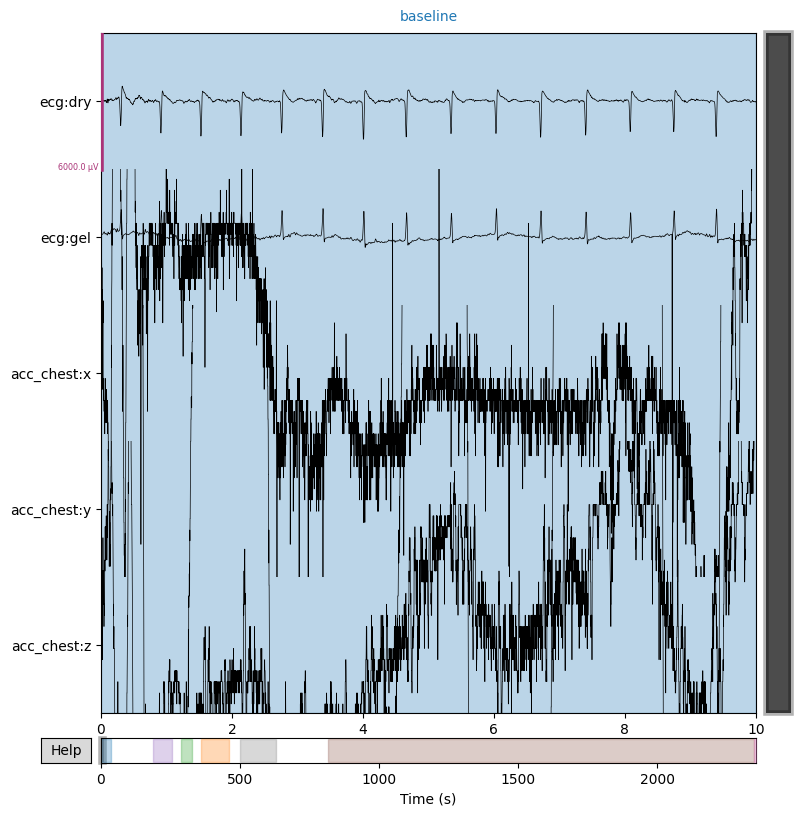

In [43]:
raw.plot(show=False, scalings=30e-4)

Be careful with the scallings as these are different units (ECG in mV, ACC in g). In interactive mode you can navigate through the acquisition.

## 2. Index channels
Awsome! Let's see the ECG when the subject was lifting a chair. Recall the events annotated and their names:

In [52]:
lift = raw.annotations[1]
lift

OrderedDict([('onset', 188.412),
             ('duration', 65.295),
             ('description', 'lift'),
             ('orig_time',
              datetime.datetime(2000, 1, 1, 0, 0, 1, tzinfo=datetime.timezone.utc))])

In [58]:
lift['orig_time'] = None
lift_annotation = mne.Annotations(**lift)
lift_annotation

<Annotations | 1 segment: lift (1)>

In [61]:
lift_activity = raw.crop_by_annotations(lift_annotation)[0]  # trim the raw data to the annotation

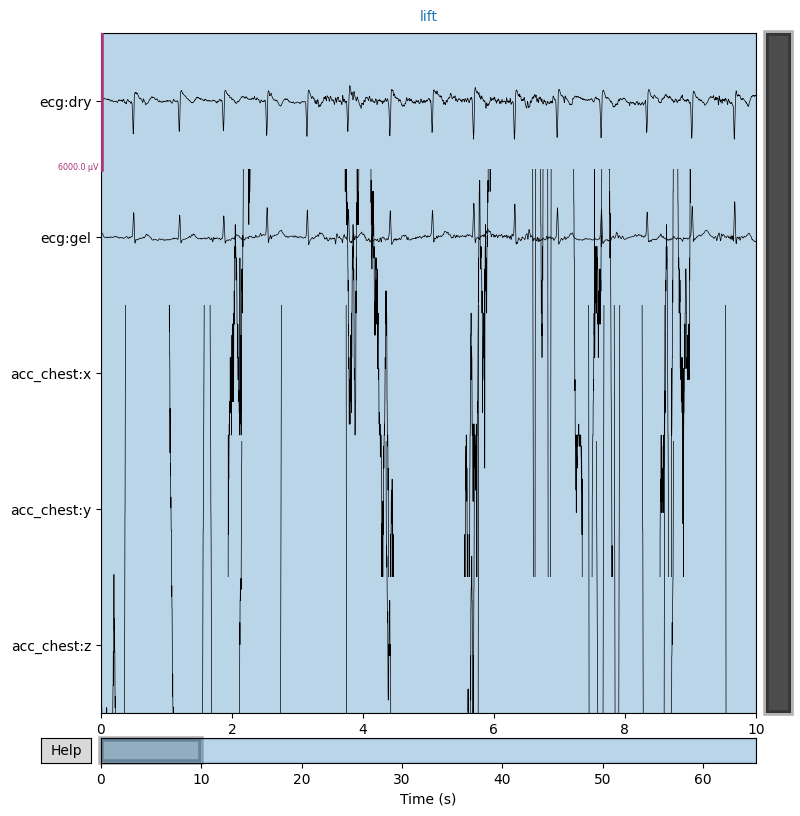

In [62]:
lift_activity.plot(show=False, scalings=30e-4)

Because ECG and ACC need different scaling, let's just get the ECG for now:

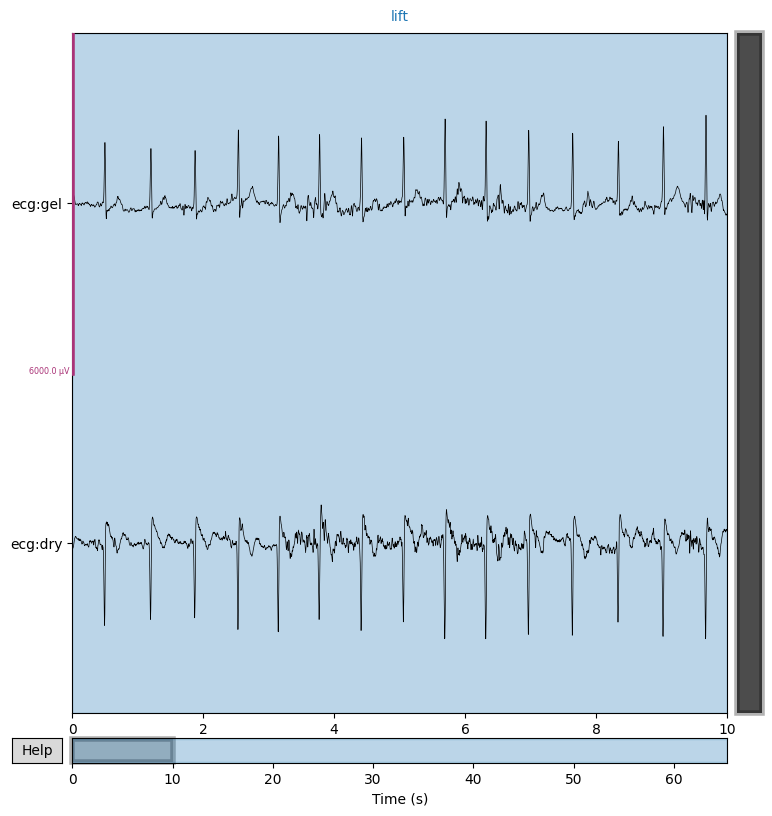

In [64]:
# Get both ECG channels
lift_activity_ecg = lift_activity.copy().pick(['ecg:gel', 'ecg:dry'])
lift_activity_ecg.plot(show=False, scalings=30e-4)

## 3. Process a raw EDF
MNE offers a diverse set of post-processing tools.
Firstly, let’s resample it to 100 Hz:

In [65]:
lift_activity_ecg.resample(100)

<RawEDF | scientisst_chest.edf, 2 x 6530 (65.3 s), ~109 kB, data loaded>

Now let's filter the signal wih a simple FIR passband from 1 to 40 Hz:

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (3.310 s)



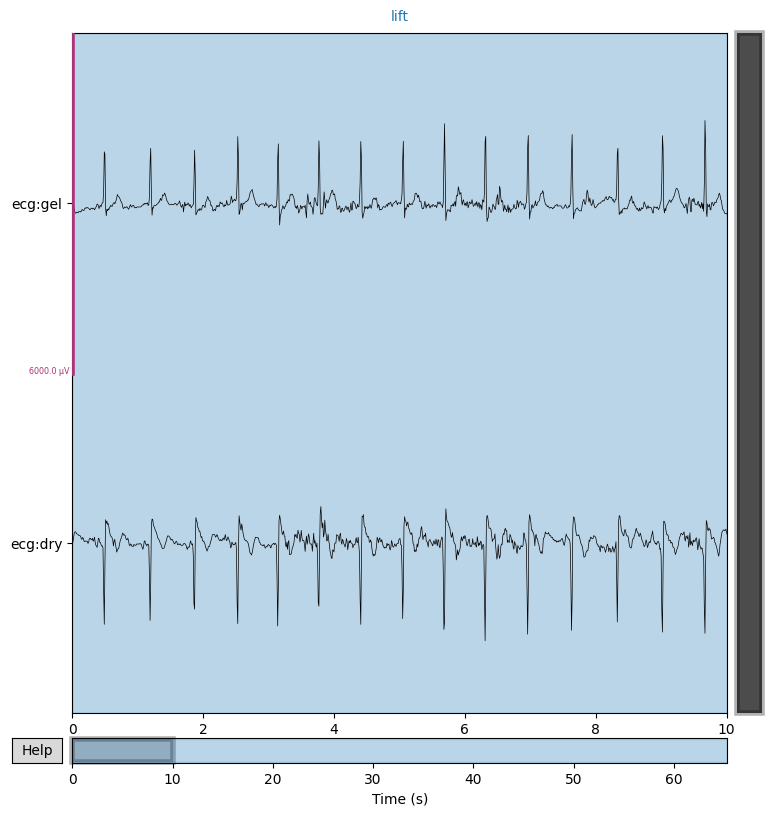

In [66]:
lift_activity_ecg.filter(1, 40)
lift_activity_ecg.plot(show=False, scalings=30e-4)

Much better! Let's normalize it:

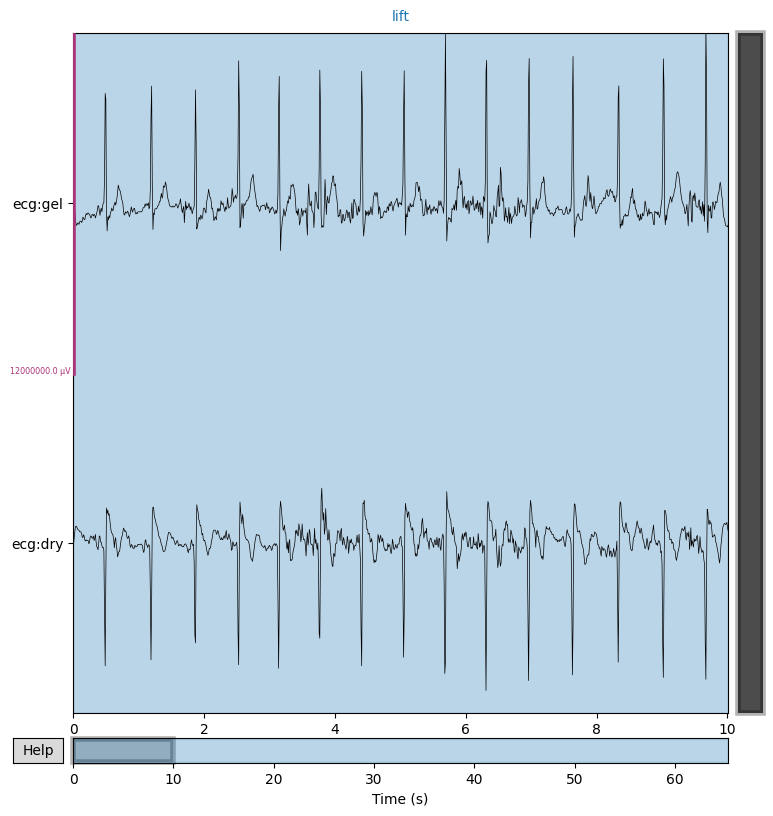

In [74]:
lift_activity_ecg.apply_function(lambda x: (x - x.mean()) / x.std())
lift_activity_ecg.plot(show=False, scalings=60e-1)

MNE was designed for EEG, MEG and MRI, but it can still be used for storing other biosignals (ECG, RESP, GSR, EMG, TEMP, etc.). You can inclusively state the type of each channel. Let's state the ECG and ACC channel types:

In [80]:
lift_activity.set_channel_types({'ecg:gel': 'ecg', 'ecg:dry': 'ecg'})
lift_activity.set_channel_types({'acc_chest:x': 'misc', 'acc_chest:y': 'misc', 'acc_chest:z': 'misc'})

<RawEDF | scientisst_chest.edf, 5 x 32649 (65.3 s), ~9 kB, data not loaded>

## 4. Stepping out of MNE

EDF objects can be re-saved, with all the modifications and processing done so-far, in a single line:

In [ ]:
!pip3 install EDFlib-Python
lift_activity.export('lift_activity_ecg.edf')

You can also convert it to NumPy array and keep going from there:

In [88]:
lift_activity_ecg.get_data()

array([[-0.02128062, -0.06725534, -0.18756444, ...,  5.52002736,
         7.14804208, -0.02128062],
       [-0.02065795,  0.01227104,  0.26148848, ...,  4.32573341,
         5.32646363, -0.02065795]])

Or to a Pandas DataFrame:

In [ ]:
!import pandas as pd
lift_activity_ecg.to_data_frame()

________
© 2023 ScientISST. All rights reserved.

Notebook offered by the [LTBio team](https://github.com/jomy-kk/LTBio).
Contact: joaomiguelsaraiva@tecnico.ulisboa.pt